## Intro Code

In [ ]:
!ls /datasets/midus/MIDUS

04652-0001-Data.tsv	 22840-0001-Data-REST.tsv  AA.tsv
22840-0001-Codebook.pdf  29282-0001-Data.tsv


In [ ]:
!pip install statsmodels==0.13.2

     |████████████████████████████████| 9.8 MB 11.4 MB/s 
     |████████████████████████████████| 233 kB 11.1 MB/s 
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
# from scipy.special import logit
# import seaborn as sns
# #from fancyimpute import IterativeImputer
# sns.set_theme(style="whitegrid")
pd.set_option('display.max_columns', 20)

In [ ]:
df_demo = pd.read_csv('/datasets/midus/MIDUS/04652-0001-Data.tsv', sep = '\t')
df_demo = df_demo.drop(columns = ['M2FAMNUM', 'SAMPLMAJ','B1STATUS','B1PAGE_M2', 'B1PRSEX'])
df_data = pd.read_csv('/datasets/midus/MIDUS/29282-0001-Data.tsv', sep = '\t')
df_milw = pd.read_csv('/datasets/midus/MIDUS/22840-0001-Data-REST.tsv', sep = '\t')

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (321,322) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (2234) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (1768,1769) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df = pd.merge(df_data, df_demo, on = ['M2ID'], how = 'left')
df = pd.merge(df, df_milw, on=['M2ID'], how= 'left')
df['M2FAMNUM'] = np.where(df['M2FAMNUM'] == ' ', df['M2ID'], df['M2FAMNUM']).astype(int)

In [ ]:
dfcut = df.copy(deep=True)
dfcut = dfcut[~dfcut.B4VB1RSP.isin([0.00, 98.00, 99.00])]
dfcut = dfcut[~dfcut.B4VB2RSP.isin([0.00, 98.00, 99.00])]
dfcut = dfcut[~dfcut.B4VB1LHF.isin([98.00, 99.00])]
dfcut = dfcut[~dfcut.B4VB2LHF.isin([98.00, 99.00])]
dfcut = dfcut[~dfcut.B4QCT_EA.isin([98.00])]
dfcut = dfcut[~dfcut.B4QCT_PA.isin([98.00])]
dfcut = dfcut[~dfcut.B4QCT_SA.isin([98.00])]
dfcut = dfcut[~dfcut.B4QCT_EN.isin([98.00])]
dfcut = dfcut[~dfcut.B4QCT_PN.isin([98.00])]
dfcut = dfcut[~dfcut.B4QCT_MD.isin([8])]

dfcut['CTQ_Total'] = dfcut.B4QCT_EA + dfcut.B4QCT_PA + dfcut.B4QCT_SA + dfcut.B4QCT_EN + dfcut.B4QCT_PN + dfcut.B4QCT_MD

model = smf.ols('B4VB1LHF ~ B4VB1RSP',dfcut).fit()
dfcut['Resid_B1'] = model.resid
model = smf.ols('B4VB2LHF ~ B4VB2RSP',dfcut).fit()
dfcut['Resid_B2'] = model.resid

dfcut['HRV'] = dfcut[['Resid_B1','Resid_B2']].mean(axis=1)

### Model 1

In [ ]:
df1 = dfcut.copy(deep=True)
md = smf.mixedlm("HRV ~ CTQ_Total", df1, groups=df1["M2FAMNUM"])
print("Model 1")
md.fit().summary()

Model 1


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: HRV       
No. Observations: 1109    Method:             REML      
No. Groups:       981     Scale:              0.9758    
Min. group size:  1       Log-Likelihood:     -1842.7880
Max. group size:  4       Converged:          Yes       
Mean group size:  1.1                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.045    0.113  0.400 0.689 -0.176  0.266
CTQ_Total     -0.001    0.003 -0.386 0.700 -0.006  0.004
Group Var      0.665    0.216                           
========================================================

"""

Rsquared = 0.6283455436781016


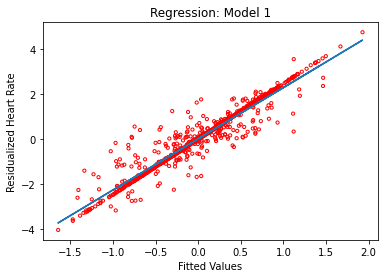

In [ ]:
res1 = md.fit()
y= df1.HRV
y_predict = res1.fittedvalues
RMSE = np.sqrt((( y - y_predict)**2).values.mean())
Rsquared = 1.0 - (np.var( y - y_predict) / np.var(y))
print(f"Rsquared = {Rsquared}")

plt.scatter(y_predict, y,s=10, facecolors='none', edgecolors='r')
m, b = np.polyfit(y_predict, y, 1)
plt.plot(y_predict, m*y_predict + b)
plt.title("Regression: Model 1")
plt.xlabel("Fitted Values")
plt.ylabel("Residualized Heart Rate");

In [ ]:
# y= df1.HRV
# y_predict = preds
# RMSE = np.sqrt((( y - y_predict)**2).values.mean())
# Rsquared = 1.0 - (np.var( y - y_predict) / np.var(y))
# Rsquared

In [ ]:
dfcut.B1PF7A = dfcut.B1PF7A.fillna(dfcut.BACF7A)
dfcut.B1PRSEX = dfcut.B1PRSEX.fillna(dfcut.BACRSEX)
dfcut.B1PA39 = dfcut.B1PA39.fillna(dfcut.BACA39)
cols = ['B1SA62A','B1SA62B','B1SA62C','B1SA62D','B1SA62E','B1SA62F','B1SA62G','B1SA62H','B1SA62I','B1SA62J','B1SA11S','B1PA7','B1PA24','B1SA11Y','B1SA11Z','B1PA6A','B1PA6B','B1PA6C','B1PA6D','B1SA11A','B1SA11B','B1SA11C','B1SA11X','B1PA26','B1SA11T']
milw_cols = ['BACAS62A','BACAS62B','BACAS62C','BACAS62D','BACAS62E','BACAS62F','BACAS62G','BACAS62H','BACAS62I','BACAS62J','BACAS11S','BACA7','BACA24','BACAS11Y','BACAS11Z','BACA6A','BACA6B','BACA6C','BACA6D','BACAS11A','BACAS11B','BACAS11C','BACAS11X','BACA26','BACAS11T']

for i in cols:
    for j in milw_cols:
        dfcut[i] = dfcut[j].fillna(dfcut[i])



dfcut.B4ZSITE = np.where(dfcut.B4ZSITE == 1, "UCLA", np.where(dfcut.B4ZSITE == 2, "aUW","Georgetown"))


In [ ]:
print('HRV')
print(dfcut.HRV.describe())
print('----------')
print('HRV by Site')
print(dfcut.groupby(['B4ZSITE']).HRV.describe())
print('----------')
print('CTQ')
print(dfcut.CTQ_Total.describe())
print('----------')
print('CTQ by Site')
print(dfcut.groupby(['B4ZSITE']).CTQ_Total.describe())
print('----------')

HRV
count    1.109000e+03
mean    -1.483234e-15
std      1.277412e+00
min     -4.054295e+00
25%     -8.613859e-01
50%      3.374560e-02
75%      7.861115e-01
max      4.740681e+00
Name: HRV, dtype: float64
----------
HRV by Site
            count      mean       std       min       25%       50%       75%  \
B4ZSITE                                                                         
Georgetown  249.0 -0.103498  1.302224 -4.054295 -1.033284 -0.219688  0.740904   
UCLA        384.0 -0.203658  1.214807 -3.586009 -0.963976 -0.153069  0.615703   
aUW         476.0  0.218436  1.282216 -3.651865 -0.618725  0.257960  1.014946   

                 max  
B4ZSITE               
Georgetown  4.740681  
UCLA        3.676152  
aUW         4.107703  
----------
CTQ
count    1109.000000
mean       38.925609
std        14.506829
min        25.000000
25%        29.000000
50%        34.000000
75%        43.000000
max       114.000000
Name: CTQ_Total, dtype: float64
----------
CTQ by Site
            

In [ ]:
dfcut = dfcut[~dfcut.B1PF7A.isin([7,8])]
dfcut.B1PF7A = np.where(dfcut.B1PF7A == 1, "White",'Non-White')
dfcut.B1PRSEX = np.where(dfcut.B1PRSEX == 1, "Male", "Female")

/shared-libs/python3.7/py/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


### Model 2

In [ ]:

md = smf.mixedlm("HRV ~ CTQ_Total + B4ZAGE + C(B1PRSEX, Treatment(reference='Female')) + C(B1PF7A, Treatment(reference='White')) + C(B4ZSITE, Treatment(reference='aUW'))", dfcut, groups=dfcut["M2FAMNUM"])
print("Model 2")
md.fit().summary()

Model 2


<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Mixed Linear Model Regression Results
===============================================================================================
Model:                         MixedLM              Dependent Variable:              HRV       
No. Observations:              1106                 Method:                          REML      
No. Groups:                    978                  Scale:                           0.9635    
Min. group size:               1                    Log-Likelihood:                  -1788.4053
Max. group size:               4                    Converged:                       Yes       
Mean group size:               1.1                                                             
-----------------------------------------------------------------------------------------------
                                                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                             1.905    0.244  7.822 0.000  1.428  2.382
C(B1PRSEX, Treatment(reference='Female'))[T.Male]    -0.117    0.075 -1.557 0.119 -0.265  0.030
C(B1PF7A, Treatment(reference='White'))[T.Non-White]  0.437    0.100  4.380 0.000  0.242  0.633
C(B4ZSITE, Treatment(reference='aUW'))[T.Georgetown] -0.143    0.103 -1.384 0.166 -0.345  0.059
C(B4ZSITE, Treatment(reference='aUW'))[T.UCLA]       -0.245    0.092 -2.659 0.008 -0.426 -0.064
CTQ_Total                                            -0.006    0.003 -2.417 0.016 -0.011 -0.001
B4ZAGE                                               -0.028    0.003 -8.227 0.000 -0.034 -0.021
Group Var                                             0.505    0.187                           
===============================================================================================

"""

Rsquared = 0.6034514526788025


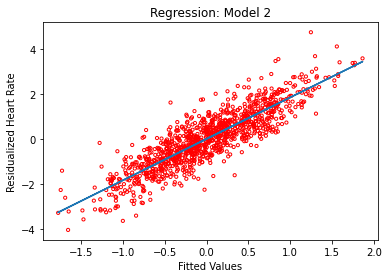

In [ ]:
res2 = md.fit()
y= dfcut.HRV
y_predict = res2.fittedvalues
RMSE = np.sqrt((( y - y_predict)**2).values.mean())
Rsquared = 1.0 - (np.var( y - y_predict) / np.var(y))
print(f"Rsquared = {Rsquared}")

plt.scatter(y_predict, y,s=10, facecolors='none', edgecolors='r')
m, b = np.polyfit(y_predict, y, 1)
plt.plot(y_predict, m*y_predict + b)
plt.title("Regression: Model 2")
plt.xlabel("Fitted Values")
plt.ylabel("Residualized Heart Rate");

In [ ]:
print(dfcut.B1PRSEX.value_counts())
print('----------')
print(dfcut.B1PF7A.value_counts())
print('----------')
print(dfcut.B4ZSITE.value_counts())
print('----------')
print(dfcut.B4ZAGE.describe())

Female    625
Male      481
Name: B1PRSEX, dtype: int64
----------
White        869
Non-White    237
Name: B1PF7A, dtype: int64
----------
aUW           475
UCLA          382
Georgetown    249
Name: B4ZSITE, dtype: int64
----------
count    1106.000000
mean       56.820072
std        11.280111
min        35.000000
25%        48.000000
50%        56.000000
75%        64.000000
max        86.000000
Name: B4ZAGE, dtype: float64


In [ ]:
print(dfcut.groupby(['B4ZSITE']).B1PRSEX.value_counts())
print('----------')
print(dfcut.groupby(['B4ZSITE']).B1PF7A.value_counts())
print('----------')
print(dfcut.groupby(['B4ZSITE']).B4ZAGE.describe())

B4ZSITE     B1PRSEX
Georgetown  Female     126
            Male       123
UCLA        Female     217
            Male       165
aUW         Female     282
            Male       193
Name: B1PRSEX, dtype: int64
----------
B4ZSITE     B1PF7A   
Georgetown  White        233
            Non-White     16
UCLA        White        351
            Non-White     31
aUW         White        285
            Non-White    190
Name: B1PF7A, dtype: int64
----------
            count       mean        std   min   25%   50%   75%   max
B4ZSITE                                                              
Georgetown  249.0  57.232932  11.696513  37.0  48.0  56.0  65.0  86.0
UCLA        382.0  57.832461  11.041235  36.0  50.0  58.0  65.0  84.0
aUW         475.0  55.789474  11.183825  35.0  47.0  55.0  63.0  86.0


In [ ]:
cols = ['B4ZAGE',"C(B1PRSEX, Treatment(reference='Female'))","C(B1PF7A, Treatment(reference='White'))","C(B4ZSITE, Treatment(reference='aUW'))"]
base = ['HRV','CTQ_Total']

for c in cols:
    for b in base:
        md = smf.mixedlm('{} ~ {}'.format(b,c), dfcut, groups=dfcut["M2FAMNUM"])
        print(f'Model with {b} against {c}')
        print(md.fit().summary())

Model with HRV against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HRV       
No. Observations: 1106    Method:             REML      
No. Groups:       978     Scale:              0.9920    
Min. group size:  1       Log-Likelihood:     -1801.0078
Max. group size:  4       Converged:          Yes       
Mean group size:  1.1                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.714    0.196  8.739 0.000  1.330  2.099
B4ZAGE        -0.030    0.003 -8.892 0.000 -0.037 -0.023
Group Var      0.535    0.198                           

Model with CTQ_Total against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CTQ_Total 
No. Observations: 1106    Method:             REML      
No. Groups:       978     Scale:         

### Model 3

In [ ]:
conditions = [
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 6),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 5) & (dfcut['B4H40'] <= 1),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 4) & (dfcut['B4H40'] >= 8) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 4) & (dfcut['B4H40'] >= 4) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 3) & (dfcut['B4H40'] >= 3.5) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 3) & (dfcut['B4H40'] >= 2) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 2) & (dfcut['B4H40'] >= 2.5) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 2) & (dfcut['B4H40'] >= 1.2) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 1) & (dfcut['B4H40'] >= 2) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 2)& (dfcut['B4H38'] == 1) & (dfcut['B4H40'] > 1) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 2),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 6),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 5) & (dfcut['B4H36'] <= 1),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 4) & (dfcut['B4H36'] >= 8) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 4) & (dfcut['B4H36'] >= 4) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 3) & (dfcut['B4H36'] >= 3.5) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 3) & (dfcut['B4H36'] >= 2) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 2) & (dfcut['B4H36'] >= 2.5) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 2) & (dfcut['B4H36'] >= 1.2) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 1) & (dfcut['B4H36'] >= 2) & (dfcut['B1PRSEX'] =='Male'),
(dfcut['B4H33'] == 1)& (dfcut['B4H34'] == 1) & (dfcut['B4H36'] > 1) & (dfcut['B1PRSEX'] =="Female"),
(dfcut['B4H33'] == 1)
]

## Say they have drank in last 30, and then say never drank, then put them into the 38/40 category
values = ['former_light/abs', 
'former_light/abs',
'former_heavy',
'former_heavy',
'former_heavy',
'former_heavy',
'former_heavy',
'former_heavy',
'former_heavy',
'former_heavy',
'former_moderate',
'current_light', 
'current_light',
'current_heavy',
'current_heavy',
'current_heavy',
'current_heavy',
'current_heavy',
'current_heavy',
'current_heavy',
'current_heavy',
'current_moderate',
]

dfcut['alc_usage'] = np.select(conditions, values)
dfcut['smokers'] = np.where(dfcut.B1PA39 == 2, "Former", np.where(dfcut.B1PA39 == 9, "Never", np.where(dfcut.B1PA39 == 1, "Current", "Other")))

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
dfcut['alc_usage'].value_counts()

current_moderate    396
current_light       203
former_light/abs    156
current_heavy       132
former_moderate     122
former_heavy         97
Name: alc_usage, dtype: int64

In [ ]:
# md = smf.mixedlm("HRV ~ CTQ_Total + B4ZAGE + B1PRSEX + C(B1PF7A, Treatment(reference='White')) + C(B4ZSITE, Treatment(reference='aUW')) + B4PBMI + B4HMETMW + alc_usage + smokers", dfcut, groups=dfcut["M2FAMNUM"])
# print("Model 3")
# md.fit().summary()
df3 = dfcut.copy(deep=True)
df3 = df3[~df3.B4PBMI.isin([998])]
df3 = df3[~df3.B4HMETMW.isin([99998])]
df3 = df3[~df3.B4H38.isin([8])]
df3 = df3[~df3.B4H40.isin([98, 97])]

In [ ]:

md = smf.mixedlm("HRV ~ CTQ_Total + B4ZAGE + C(B1PRSEX, Treatment(reference='Female')) + C(B1PF7A, Treatment(reference='White')) + C(B4ZSITE, Treatment(reference='aUW')) + B4PBMI + B4HMETMW + C(alc_usage, Treatment(reference='former_light/abs')) + C(smokers, Treatment(reference='Never'))", df3, groups=df3["M2FAMNUM"])
print("Model 3")
md.fit().summary()

Model 3


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Mixed Linear Model Regression Results
====================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     HRV       
No. Observations:                     1097                        Method:                                 REML      
No. Groups:                           972                         Scale:                                  0.9612    
Min. group size:                      1                           Log-Likelihood:                         -1784.3780
Max. group size:                      4                           Converged:                              Yes       
Mean group size:                      1.1                                                                           
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.814    0.318  5.702 0.000  1.190  2.437
C(B1PRSEX, Treatment(reference='Female'))[T.Male]                         -0.176    0.077 -2.292 0.022 -0.327 -0.026
C(B1PF7A, Treatment(reference='White'))[T.Non-White]                       0.399    0.102  3.908 0.000  0.199  0.599
C(B4ZSITE, Treatment(reference='aUW'))[T.Georgetown]                      -0.171    0.103 -1.661 0.097 -0.373  0.031
C(B4ZSITE, Treatment(reference='aUW'))[T.UCLA]                            -0.243    0.092 -2.634 0.008 -0.424 -0.062
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_heavy]     0.078    0.151  0.518 0.604 -0.218  0.374
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_light]    -0.126    0.131 -0.959 0.337 -0.383  0.131
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_moderate]  0.079    0.120  0.660 0.509 -0.156  0.315
C(alc_usage, Treatment(reference='former_light/abs'))[T.former_heavy]     -0.159    0.164 -0.972 0.331 -0.481  0.162
C(alc_usage, Treatment(reference='former_light/abs'))[T.former_moderate]  -0.242    0.148 -1.630 0.103 -0.532  0.049
C(smokers, Treatment(reference='Never'))[T.Current]                        0.256    0.116  2.196 0.028  0.028  0.484
C(smokers, Treatment(reference='Never'))[T.Former]                         0.089    0.087  1.019 0.308 -0.082  0.261
CTQ_Total                                                                 -0.007    0.003 -2.643 0.008 -0.012 -0.002
B4ZAGE                                                                    -0.027    0.003 -7.770 0.000 -0.034 -0.020
B4PBMI                                                                     0.002    0.006  0.268 0.789 -0.010  0.013
B4HMETMW                                                                   0.000    0.000  1.578 0.115 -0.000  0.000
Group Var                                                                  0.483    0.185                           
====================================================================================================================

"""

Rsquared = 0.6009968836006703


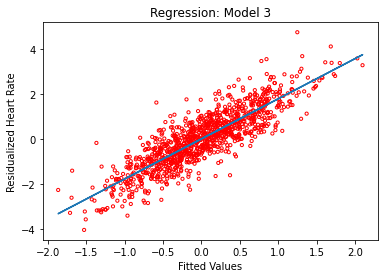

In [ ]:
res3 = md.fit()
y= df3.HRV
y_predict = res3.fittedvalues
RMSE = np.sqrt((( y - y_predict)**2).values.mean())
Rsquared = 1.0 - (np.var( y - y_predict) / np.var(y))
print(f"Rsquared = {Rsquared}")

plt.scatter(y_predict, y,s=10, facecolors='none', edgecolors='r')
m, b = np.polyfit(y_predict, y, 1)
plt.plot(y_predict, m*y_predict + b)
plt.title("Regression: Model 3")
plt.xlabel("Fitted Values")
plt.ylabel("Residualized Heart Rate");

In [ ]:
print(df3.B1PRSEX.value_counts())
print('----------')
print(df3.B1PF7A.value_counts())
print('----------')
print(df3.B4ZSITE.value_counts())
print('----------')
print(df3.B4ZAGE.describe())
print('----------')
print(df3.alc_usage.value_counts())
print('----------')
print(df3.smokers.value_counts())
print('----------')
print(df3.B4PBMI.describe())
print('----------')
print(df3.B4HMETMW.describe())
print('----------')

Female    621
Male      476
Name: B1PRSEX, dtype: int64
----------
White        862
Non-White    235
Name: B1PF7A, dtype: int64
----------
aUW           470
UCLA          379
Georgetown    248
Name: B4ZSITE, dtype: int64
----------
count    1097.000000
mean       56.842297
std        11.313294
min        35.000000
25%        48.000000
50%        56.000000
75%        64.000000
max        86.000000
Name: B4ZAGE, dtype: float64
----------
current_moderate    395
current_light       201
former_light/abs    155
current_heavy       129
former_moderate     121
former_heavy         96
Name: alc_usage, dtype: int64
----------
Never      603
Former     345
Current    149
Name: smokers, dtype: int64
----------
count    1097.000000
mean       29.725314
std         6.491789
min        14.990000
25%        25.260000
50%        28.590000
75%        32.980000
max        65.090000
Name: B4PBMI, dtype: float64
----------
count     1097.000000
mean      1406.555880
std       2267.200836
min          0.00

In [ ]:
print(df3.groupby(['B4ZSITE']).B1PRSEX.value_counts())
print('----------')
print(df3.groupby(['B4ZSITE']).B1PF7A.value_counts())
print('----------')
print(df3.groupby(['B4ZSITE']).B4ZAGE.describe())
print('----------')
print(df3.groupby(['B4ZSITE']).alc_usage.value_counts())
print('----------')
print(df3.groupby(['B4ZSITE']).smokers.value_counts())
print('----------')
print(df3.groupby(['B4ZSITE']).B4PBMI.describe())
print('----------')
print(df3.groupby(['B4ZSITE']).B4HMETMW.describe())
print('----------')

B4ZSITE     B1PRSEX
Georgetown  Female     125
            Male       123
UCLA        Female     216
            Male       163
aUW         Female     280
            Male       190
Name: B1PRSEX, dtype: int64
----------
B4ZSITE     B1PF7A   
Georgetown  White        232
            Non-White     16
UCLA        White        348
            Non-White     31
aUW         White        282
            Non-White    188
Name: B1PF7A, dtype: int64
----------
            count       mean        std   min   25%   50%   75%   max
B4ZSITE                                                              
Georgetown  248.0  57.258065  11.713428  37.0  48.0  56.5  65.0  86.0
UCLA        379.0  57.823219  11.079935  36.0  49.5  58.0  65.0  84.0
aUW         470.0  55.831915  11.225136  35.0  47.0  55.0  63.0  86.0
----------
B4ZSITE     alc_usage       
Georgetown  current_moderate    106
            current_light        37
            former_light/abs     31
            former_moderate      29
           

In [ ]:
cols = ['B4ZAGE',"C(B1PRSEX, Treatment(reference='Female'))","C(B1PF7A, Treatment(reference='White'))","C(B4ZSITE, Treatment(reference='aUW'))","C(alc_usage, Treatment(reference='former_light/abs'))","C(smokers, Treatment(reference='Never'))",'B4PBMI','B4HMETMW']
base = ['HRV','CTQ_Total']

for c in cols:
    for b in base:
        md = smf.mixedlm('{} ~ {}'.format(b,c), df3, groups=df3["M2FAMNUM"])
        print(f'Model with {b} against {c}')
        print(md.fit().summary())

Model with HRV against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HRV       
No. Observations: 1097    Method:             REML      
No. Groups:       972     Scale:              1.0046    
Min. group size:  1       Log-Likelihood:     -1783.3500
Max. group size:  4       Converged:          Yes       
Mean group size:  1.1                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.729    0.196  8.837 0.000  1.345  2.112
B4ZAGE        -0.030    0.003 -8.965 0.000 -0.037 -0.024
Group Var      0.512    0.194                           

Model with CTQ_Total against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CTQ_Total 
No. Observations: 1097    Method:             REML      
No. Groups:       972     Scale:         


### Model 4

In [ ]:
dfm4 = df3.copy(deep=True)
dfm4 = dfm4[~dfm4.B4XTC_40.isin([8,9])]
dfm4 = dfm4[~dfm4.B4XTC_57.isin([8,9])]
dfm4 = dfm4[~dfm4.B4XTC_122.isin([8,9])]
dfm4 = dfm4[~dfm4.B4XTC_358.isin([8,9])]
dfm4 = dfm4[~dfm4.B4XTC_242.isin([8,9])]

dfm4.B4XTC_40 = np.where(dfm4.B4XTC_40 == 1, "Yes", "No")
dfm4.B4XTC_57 = np.where(dfm4.B4XTC_57 == 1, "Yes", "No")
dfm4.B4XTC_122 = np.where(dfm4.B4XTC_122 == 1, "Yes", "No")
dfm4.B4XTC_358 = np.where(dfm4.B4XTC_358 == 1, "Yes", "No")
dfm4.B4XTC_242 = np.where(dfm4.B4XTC_242 == 1, "Yes", "No")

In [ ]:

md = smf.mixedlm("HRV ~ CTQ_Total + B4ZAGE + C(B1PRSEX, Treatment(reference='Female')) + C(B1PF7A, Treatment(reference='White')) + C(B4ZSITE, Treatment(reference='aUW')) + B4PBMI + B4HMETMW + C(alc_usage, Treatment(reference='former_light/abs')) + C(smokers, Treatment(reference='Never')) + C(B4XTC_40, Treatment(reference='No')) + C(B4XTC_57, Treatment(reference='No')) + C(B4XTC_122, Treatment(reference='No')) + C(B4XTC_358, Treatment(reference='No')) + C(B4XTC_242, Treatment(reference='No'))", dfm4, groups=dfm4["M2FAMNUM"])
print("Model 4")
md.fit().summary()

Model 4


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Mixed Linear Model Regression Results
====================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     HRV       
No. Observations:                     994                         Method:                                 REML      
No. Groups:                           892                         Scale:                                  1.0597    
Min. group size:                      1                           Log-Likelihood:                         -1621.4147
Max. group size:                      4                           Converged:                              Yes       
Mean group size:                      1.1                                                                           
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.677    0.351  4.775 0.000  0.989  2.365
C(B1PRSEX, Treatment(reference='Female'))[T.Male]                         -0.198    0.081 -2.431 0.015 -0.357 -0.038
C(B1PF7A, Treatment(reference='White'))[T.Non-White]                       0.391    0.110  3.558 0.000  0.176  0.606
C(B4ZSITE, Treatment(reference='aUW'))[T.Georgetown]                      -0.136    0.107 -1.277 0.201 -0.345  0.073
C(B4ZSITE, Treatment(reference='aUW'))[T.UCLA]                            -0.206    0.096 -2.147 0.032 -0.393 -0.018
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_heavy]     0.080    0.161  0.497 0.619 -0.235  0.395
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_light]    -0.132    0.136 -0.968 0.333 -0.399  0.135
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_moderate]  0.052    0.125  0.416 0.678 -0.193  0.296
C(alc_usage, Treatment(reference='former_light/abs'))[T.former_heavy]     -0.132    0.171 -0.769 0.442 -0.468  0.204
C(alc_usage, Treatment(reference='former_light/abs'))[T.former_moderate]  -0.206    0.154 -1.336 0.182 -0.509  0.096
C(smokers, Treatment(reference='Never'))[T.Current]                        0.264    0.126  2.088 0.037  0.016  0.512
C(smokers, Treatment(reference='Never'))[T.Former]                         0.102    0.091  1.113 0.266 -0.077  0.280
C(B4XTC_40, Treatment(reference='No'))[T.Yes]                              0.135    0.090  1.497 0.135 -0.042  0.311
C(B4XTC_57, Treatment(reference='No'))[T.Yes]                             -0.007    0.085 -0.080 0.936 -0.173  0.160
C(B4XTC_122, Treatment(reference='No'))[T.Yes]                            -0.266    0.094 -2.849 0.004 -0.450 -0.083
C(B4XTC_358, Treatment(reference='No'))[T.Yes]                            -0.165    0.085 -1.936 0.053 -0.333  0.002
C(B4XTC_242, Treatment(reference='No'))[T.Yes]                            -0.281    0.106 -2.663 0.008 -0.489 -0.074
CTQ_Total                                                                 -0.006    0.003 -1.988 0.047 -0.011 -0.000
B4ZAGE                                                                    -0.026    0.004 -6.388 0.000 -0.033 -0.018
B4PBMI                                                                     0.005    0.006  0.718 0.473 -0.008  0.017
B4HMETMW                                                                   0.000    0.000  1.201 0.230 -0.000  0.000
Group Var                                                                  0.367    0.173                           
====================================================================================================================

"""

In [ ]:
res4 = md.fit()

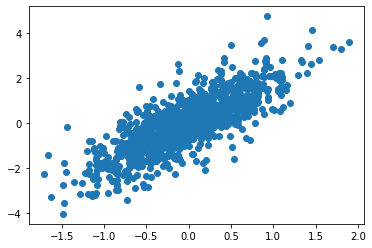

In [ ]:
preds = res4.fittedvalues
plt.scatter(preds,dfm4.HRV)

In [ ]:
# y= dfm4.HRV
# y_predict = res4.fittedvalues
# RMSE = np.sqrt((( y - y_predict)**2).values.mean())
# Rsquared = 1.0 - (np.var( y - y_predict) / np.var(y))
# Rsquared

Rsquared = 0.5148620175198397


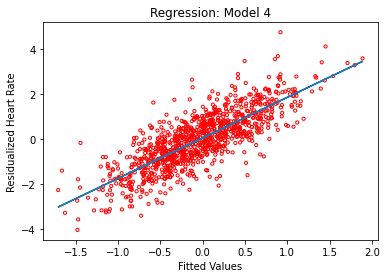

In [ ]:
res4 = md.fit()
y= dfm4.HRV
y_predict = res4.fittedvalues
RMSE = np.sqrt((( y - y_predict)**2).values.mean())
Rsquared = 1.0 - (np.var( y - y_predict) / np.var(y))
print(f"Rsquared = {Rsquared}")

plt.scatter(y_predict, y,s=10, facecolors='none', edgecolors='r')
m, b = np.polyfit(y_predict, y, 1)
plt.plot(y_predict, m*y_predict + b)
plt.title("Regression: Model 4")
plt.xlabel("Fitted Values")
plt.ylabel("Residualized Heart Rate");

In [ ]:
# plt.scatter(preds,dfm4.HRV)


In [ ]:
np.corrcoef(preds, dfm4.HRV)

array([[1.       , 0.8011356],
       [0.8011356, 1.       ]])

In [ ]:
# md.fit().rsquared

In [ ]:
print(dfm4.B1PRSEX.value_counts())
print('----------')
print(dfm4.B1PF7A.value_counts())
print('----------')
print(dfm4.B4ZSITE.value_counts())
print('----------')
print(dfm4.B4ZAGE.describe())
print('----------')
print(dfm4.alc_usage.value_counts())
print('----------')
print(dfm4.smokers.value_counts())
print('----------')
print(dfm4.B4PBMI.describe())
print('----------')
print(dfm4.B4HMETMW.describe())
print('----------')
print(dfm4.B4XTC_40.value_counts())
print('----------')
print(dfm4.B4XTC_57.value_counts())
print('----------')
print(dfm4.B4XTC_122.value_counts())
print('----------')
print(dfm4.B4XTC_358.value_counts())
print('----------')
print(dfm4.B4XTC_242.value_counts())
print('----------')

Female    578
Male      416
Name: B1PRSEX, dtype: int64
----------
White        795
Non-White    199
Name: B1PF7A, dtype: int64
----------
aUW           405
UCLA          355
Georgetown    234
Name: B4ZSITE, dtype: int64
----------
count    994.000000
mean      57.687123
std       11.192794
min       35.000000
25%       49.000000
50%       57.000000
75%       65.000000
max       86.000000
Name: B4ZAGE, dtype: float64
----------
current_moderate    362
current_light       184
former_light/abs    142
current_heavy       109
former_moderate     109
former_heavy         88
Name: alc_usage, dtype: int64
----------
Never      549
Former     322
Current    123
Name: smokers, dtype: int64
----------
count    994.000000
mean      29.833260
std        6.493596
min       14.990000
25%       25.332500
50%       28.635000
75%       33.027500
max       65.090000
Name: B4PBMI, dtype: float64
----------
count      994.000000
mean      1338.518913
std       2165.521329
min          0.000000
25%        

In [ ]:
print(dfm4.groupby(['B4ZSITE']).B1PRSEX.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B1PF7A.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4ZAGE.describe())
print('----------')
print(dfm4.groupby(['B4ZSITE']).alc_usage.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).smokers.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4PBMI.describe())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4HMETMW.describe())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4XTC_40.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4XTC_57.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4XTC_122.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4XTC_358.value_counts())
print('----------')
print(dfm4.groupby(['B4ZSITE']).B4XTC_242.value_counts())
print('----------')

B4ZSITE     B1PRSEX
Georgetown  Female     122
            Male       112
UCLA        Female     207
            Male       148
aUW         Female     249
            Male       156
Name: B1PRSEX, dtype: int64
----------
B4ZSITE     B1PF7A   
Georgetown  White        220
            Non-White     14
UCLA        White        326
            Non-White     29
aUW         White        249
            Non-White    156
Name: B1PF7A, dtype: int64
----------
            count       mean        std   min   25%   50%   75%   max
B4ZSITE                                                              
Georgetown  234.0  57.944444  11.523493  37.0  49.0  58.0  66.0  86.0
UCLA        355.0  58.025352  11.029592  36.0  50.0  58.0  65.0  84.0
aUW         405.0  57.241975  11.153773  35.0  49.0  57.0  65.0  86.0
----------
B4ZSITE     alc_usage       
Georgetown  current_moderate     97
            current_light        37
            former_light/abs     29
            current_heavy        28
           

In [ ]:
cols = ['B4ZAGE',"C(B1PRSEX, Treatment(reference='Female'))","C(B1PF7A, Treatment(reference='White'))","C(B4ZSITE, Treatment(reference='aUW'))","C(alc_usage, Treatment(reference='former_light/abs'))","C(smokers, Treatment(reference='Never'))",
'B4PBMI','B4HMETMW',"C(B4XTC_40, Treatment(reference='No'))","C(B4XTC_57, Treatment(reference='No'))","C(B4XTC_122, Treatment(reference='No'))","C(B4XTC_358, Treatment(reference='No'))","C(B4XTC_242, Treatment(reference='No'))"]
base = ['HRV','CTQ_Total']

for c in cols:
    for b in base:
        md = smf.mixedlm('{} ~ {}'.format(b,c), dfm4, groups=dfm4["M2FAMNUM"])
        print(f'Model with {b} against {c}')
        print(md.fit().summary())

Model with HRV against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HRV       
No. Observations: 994     Method:             REML      
No. Groups:       892     Scale:              1.0958    
Min. group size:  1       Log-Likelihood:     -1620.1273
Max. group size:  4       Converged:          Yes       
Mean group size:  1.1                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.556    0.210  7.427 0.000  1.146  1.967
B4ZAGE        -0.028    0.004 -7.794 0.000 -0.035 -0.021
Group Var      0.424    0.189                           

Model with CTQ_Total against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CTQ_Total 
No. Observations: 994     Method:             REML      
No. Groups:       892     Scale:         


### Model 5

In [ ]:
dfm5 = df3.copy(deep=True)

floats = ['B1SA62A',
'B1SA11S',
'B1SA11Y',
'B1SA11A',
'B1SA11X',
'B1PA26',
'B1SA11T',
'B1SA62B',
'B1PA7',
'B1SA11Z',
'B1SA11B',
'B4H1I',
'B4H1P',
'B4H1V',
'B1SA62C',
'B1PA24',
'B1PA6A',
'B1SA11C',
'B4H1N',
'B1SA62D',
'B4H1A',
'B1PA6B',
'B4H1J',
'B1SA62E',
'B4H1B',
'B1PA6C',
'B4H1K',
'B1SA62F',
'B4H1C',
'B1PA6D',
'B4H1L',
'B1SA62G',
'B4H1D',
'B4H1F',
'B1SA62H',
'B4H1E',
'B1SA62I',
'B4H1H',
'B1SA62J',]

for i in floats:
    dfm5[i] = dfm5[i].astype(int)

dfm5 = dfm5[~dfm5.B1SA62A.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62B.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62C.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62D.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62E.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62F.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62H.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62I.isin([8])]
dfm5 = dfm5[~dfm5.B1SA62J.isin([8])]

dfm5 = dfm5[~dfm5.B1PA7.isin([7])]
dfm5 = dfm5[~dfm5.B1PA24.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1A.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1B.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1C.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1D.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1E.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1F.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1H.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1J.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1K.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1L.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1I.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1N.isin([3,7])]
dfm5 = dfm5[~dfm5.B4H1P.isin([3,7,8])]
dfm5 = dfm5[~dfm5.B4H1V.isin([3,7,8])]

'''If the respondent answered No to each of the categories within the larger group, then 1 else 0
For example, in Onc_Do, the respondent said No (equals 2) to both the B1 study and B4 study, then they are a 1. 
If they said yes in either, they are a 0.
This reference variable is coded the opposite of the other variables'''
dfm5["SA_Rx"] = 1*((dfm5['B1SA62A'] == 2) & (dfm5['B1SA62B'] == 2) & (dfm5['B1SA62C'] == 2) & (dfm5['B1SA62D'] == 2) & (dfm5['B1SA62E'] == 2) & (dfm5['B1SA62F'] == 2) & (dfm5['B1SA62G'] == 2) & (dfm5['B1SA62H'] == 2) & (dfm5['B1SA62I'] == 2) & (dfm5['B1SA62J'] == 2))
dfm5["CV_Do"] = 1*((dfm5['B1SA11S'] == 2) & (dfm5['B1PA7'] == 2) & (dfm5['B1PA24'] == 2) & (dfm5['B4H1A'] == 2) & (dfm5['B4H1B'] == 2) & (dfm5['B4H1C'] == 2) & (dfm5['B4H1D'] == 2) & (dfm5['B4H1E'] == 2) & (dfm5['B4H1H'] == 2))
dfm5["CNS_Do"] = 1*((dfm5['B1SA11Y'] == 2) & (dfm5['B1SA11Z'] == 2) & (dfm5['B1PA6A'] == 2) & (dfm5['B1PA6B'] == 2) & (dfm5['B1PA6C'] == 2) & (dfm5['B1PA6D'] == 2) & (dfm5['B4H1F'] == 2))
dfm5["Resp_Do"] = 1*((dfm5['B1SA11A'] == 2) & (dfm5['B1SA11B'] == 2) & (dfm5['B1SA11C'] == 2) & (dfm5['B4H1J'] == 2) & (dfm5['B4H1K'] == 2) & (dfm5['B4H1L'] == 2))
dfm5["Endo_Do"] = 1*((dfm5['B1SA11X'] == 2) & (dfm5['B4H1I'] == 2) & (dfm5['B4H1N'] == 2))
dfm5["Onc_Do"] = 1*((dfm5['B1PA26'] == 2) & (dfm5['B4H1P'] == 2))
dfm5["Psych_Do"] = 1*((dfm5['B1SA11T'] == 2) & (dfm5['B4H1V'] == 2))


In [ ]:
dfm5.CV_Do.value_counts()

0    685
1    301
Name: CV_Do, dtype: int64

In [ ]:
dfm5.SA_Rx = np.where(dfm5.SA_Rx == 1, "No", "Yes")
dfm5.CV_Do = np.where(dfm5.CV_Do == 1, "No", "Yes")
dfm5.CNS_Do = np.where(dfm5.CNS_Do == 1, "No", "Yes")
dfm5.Resp_Do = np.where(dfm5.Resp_Do == 1, "No", "Yes")
dfm5.Endo_Do = np.where(dfm5.Endo_Do == 1, "No", "Yes")
dfm5.Onc_Do = np.where(dfm5.Onc_Do == 1, "No", "Yes")
dfm5.Psych_Do = np.where(dfm5.Psych_Do == 1, "No", "Yes")

In [ ]:
md = smf.mixedlm("HRV ~ CTQ_Total + B4ZAGE + C(B1PRSEX, Treatment(reference='Female')) + C(B1PF7A, Treatment(reference='White')) + C(B4ZSITE, Treatment(reference='aUW')) + B4PBMI + B4HMETMW + C(alc_usage, Treatment(reference='former_light/abs')) + C(smokers, Treatment(reference='Never'))  + C(SA_Rx, Treatment(reference='No')) + C(CV_Do, Treatment(reference='No')) + C(CNS_Do, Treatment(reference='No')) + C(Resp_Do, Treatment(reference='No')) +C(Endo_Do, Treatment(reference='No'))  + C(Onc_Do, Treatment(reference='No')) + C(Psych_Do, Treatment(reference='No'))", dfm5, groups=dfm5["M2FAMNUM"])
print("Model 5")
md.fit().summary()

Model 5


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Mixed Linear Model Regression Results
====================================================================================================================
Model:                                MixedLM                     Dependent Variable:                     HRV       
No. Observations:                     986                         Method:                                 REML      
No. Groups:                           883                         Scale:                                  0.8365    
Min. group size:                      1                           Log-Likelihood:                         -1610.9966
Max. group size:                      4                           Converged:                              Yes       
Mean group size:                      1.1                                                                           
--------------------------------------------------------------------------------------------------------------------
                                                                          Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.770    0.341  5.185 0.000  1.101  2.439
C(B1PRSEX, Treatment(reference='Female'))[T.Male]                         -0.173    0.082 -2.118 0.034 -0.334 -0.013
C(B1PF7A, Treatment(reference='White'))[T.Non-White]                       0.408    0.110  3.713 0.000  0.193  0.624
C(B4ZSITE, Treatment(reference='aUW'))[T.Georgetown]                      -0.235    0.111 -2.113 0.035 -0.452 -0.017
C(B4ZSITE, Treatment(reference='aUW'))[T.UCLA]                            -0.287    0.098 -2.925 0.003 -0.480 -0.095
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_heavy]     0.108    0.161  0.672 0.502 -0.208  0.424
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_light]    -0.115    0.138 -0.835 0.404 -0.385  0.155
C(alc_usage, Treatment(reference='former_light/abs'))[T.current_moderate]  0.072    0.127  0.569 0.569 -0.177  0.321
C(alc_usage, Treatment(reference='former_light/abs'))[T.former_heavy]     -0.194    0.174 -1.115 0.265 -0.534  0.147
C(alc_usage, Treatment(reference='former_light/abs'))[T.former_moderate]  -0.195    0.155 -1.255 0.209 -0.498  0.109
C(smokers, Treatment(reference='Never'))[T.Current]                        0.304    0.126  2.411 0.016  0.057  0.551
C(smokers, Treatment(reference='Never'))[T.Former]                         0.170    0.092  1.841 0.066 -0.011  0.351
C(SA_Rx, Treatment(reference='No'))[T.Yes]                                 0.123    0.124  0.991 0.321 -0.120  0.365
C(CV_Do, Treatment(reference='No'))[T.Yes]                                -0.084    0.091 -0.922 0.357 -0.262  0.094
C(CNS_Do, Treatment(reference='No'))[T.Yes]                                0.185    0.120  1.532 0.125 -0.052  0.421
C(Resp_Do, Treatment(reference='No'))[T.Yes]                              -0.272    0.101 -2.690 0.007 -0.470 -0.074
C(Endo_Do, Treatment(reference='No'))[T.Yes]                              -0.045    0.093 -0.480 0.631 -0.227  0.138
C(Onc_Do, Treatment(reference='No'))[T.Yes]                               -0.071    0.109 -0.651 0.515 -0.285  0.143
C(Psych_Do, Treatment(reference='No'))[T.Yes]                             -0.186    0.095 -1.956 0.050 -0.372  0.000
CTQ_Total                                                                 -0.006    0.003 -1.929 0.054 -0.012  0.000
B4ZAGE                                                                    -0.028    0.004 -7.075 0.000 -0.036 -0.020
B4PBMI                                                                     0.008    0.006  1.233 0.218 -0.005  0.020
B4HMETMW                                                                   0.000    0.000  1.485 0.137 -0.000  0.000
Group Var    

In [ ]:
print(dfm5.B1PRSEX.value_counts())
print('----------')
print(dfm5.B1PF7A.value_counts())
print('----------')
print(dfm5.B4ZSITE.value_counts())
print('----------')
print(dfm5.B4ZAGE.describe())
print('----------')
print(dfm5.alc_usage.value_counts())
print('----------')
print(dfm5.smokers.value_counts())
print('----------')
print(dfm5.B4PBMI.describe())
print('----------')
print(dfm5.B4HMETMW.describe())
print('----------')
print(dfm5.SA_Rx.value_counts())
print('----------')
print(dfm5.CV_Do.value_counts())
print('----------')
print(dfm5.CNS_Do.value_counts())
print('----------')
print(dfm5.Resp_Do.value_counts())
print('----------')
print(dfm5.Endo_Do.value_counts())
print('----------')
print(dfm5.Onc_Do.value_counts())
print('----------')
print(dfm5.Psych_Do.value_counts())
print('----------')

Female    557
Male      429
Name: B1PRSEX, dtype: int64
----------
White        776
Non-White    210
Name: B1PF7A, dtype: int64
----------
aUW           426
UCLA          353
Georgetown    207
Name: B4ZSITE, dtype: int64
----------
count    986.000000
mean      56.742394
std       11.319834
min       35.000000
25%       48.000000
50%       56.000000
75%       64.000000
max       86.000000
Name: B4ZAGE, dtype: float64
----------
current_moderate    354
current_light       183
former_light/abs    139
former_moderate     114
current_heavy       111
former_heavy         85
Name: alc_usage, dtype: int64
----------
Never      553
Former     307
Current    126
Name: smokers, dtype: int64
----------
count    986.000000
mean      29.748499
std        6.505786
min       14.990000
25%       25.297500
50%       28.585000
75%       33.042500
max       65.090000
Name: B4PBMI, dtype: float64
----------
count      986.000000
mean      1407.185903
std       2323.378624
min          0.000000
25%        

In [ ]:
print(dfm5.groupby(['B4ZSITE']).B1PRSEX.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).B1PF7A.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).B4ZAGE.describe())
print('----------')
print(dfm5.groupby(['B4ZSITE']).alc_usage.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).smokers.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).B4PBMI.describe())
print('----------')
print(dfm5.groupby(['B4ZSITE']).B4HMETMW.describe())
print('----------')
print(dfm5.groupby(['B4ZSITE']).SA_Rx.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).CV_Do.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).CNS_Do.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).Resp_Do.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).Endo_Do.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).Onc_Do.value_counts())
print('----------')
print(dfm5.groupby(['B4ZSITE']).Psych_Do.value_counts())
print('----------')

B4ZSITE     B1PRSEX
Georgetown  Male       105
            Female     102
UCLA        Female     198
            Male       155
aUW         Female     257
            Male       169
Name: B1PRSEX, dtype: int64
----------
B4ZSITE     B1PF7A   
Georgetown  White        192
            Non-White     15
UCLA        White        325
            Non-White     28
aUW         White        259
            Non-White    167
Name: B1PF7A, dtype: int64
----------
            count       mean        std   min   25%   50%   75%   max
B4ZSITE                                                              
Georgetown  207.0  56.980676  11.387679  37.0  48.0  56.0  64.0  84.0
UCLA        353.0  57.691218  11.188385  36.0  49.0  57.0  65.0  83.0
aUW         426.0  55.840376  11.351408  35.0  47.0  55.0  63.0  86.0
----------
B4ZSITE     alc_usage       
Georgetown  current_moderate     88
            current_light        31
            former_moderate      28
            former_light/abs     26
           

In [ ]:
cols = ['B4ZAGE',"C(B1PRSEX, Treatment(reference='Female'))","C(B1PF7A, Treatment(reference='White'))","C(B4ZSITE, Treatment(reference='aUW'))","C(alc_usage, Treatment(reference='former_light/abs'))","C(smokers, Treatment(reference='Never'))",
'B4PBMI','B4HMETMW',"C(SA_Rx, Treatment(reference='No'))","C(CV_Do, Treatment(reference='No'))","C(CNS_Do, Treatment(reference='No'))","C(Resp_Do, Treatment(reference='No'))","C(Endo_Do, Treatment(reference='No'))","C(Onc_Do, Treatment(reference='No'))","C(Psych_Do, Treatment(reference='No'))"]
base = ['HRV','CTQ_Total']

for c in cols:
    for b in base:
        md = smf.mixedlm('{} ~ {}'.format(b,c), dfm5, groups=dfm5["M2FAMNUM"])
        print(f'Model with {b} against {c}')
        print(md.fit().summary())

Model with HRV against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: HRV       
No. Observations: 986     Method:             REML      
No. Groups:       883     Scale:              0.9442    
Min. group size:  1       Log-Likelihood:     -1609.0417
Max. group size:  4       Converged:          Yes       
Mean group size:  1.1                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      1.809    0.208  8.707 0.000  1.402  2.217
B4ZAGE        -0.032    0.004 -8.854 0.000 -0.039 -0.025
Group Var      0.595    0.228                           

Model with CTQ_Total against B4ZAGE
         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: CTQ_Total 
No. Observations: 986     Method:             REML      
No. Groups:       883     Scale:         

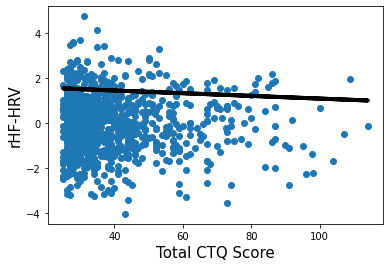

In [ ]:
plt.scatter(dfm4.CTQ_Total,dfm4.HRV)
yhat = -0.006*dfm4.CTQ_Total + 1.677
fig = plt.plot(dfm4.CTQ_Total,yhat, lw=4, c='black' , label = 'Fig 1. Model Four Linear Regression of Total Childhood Trauma Score and Residualized High Frequency Heart Rate Variability')
plt.xlabel('Total CTQ Score' , fontsize = 15)
plt.ylabel('rHF-HRV' , fontsize = 15)
plt.show()

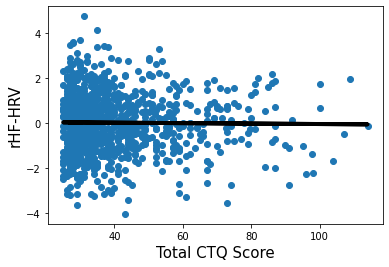

In [ ]:
plt.scatter(df1.CTQ_Total,df1.HRV)
yhat = -0.001*df1.CTQ_Total + 0.045
fig = plt.plot(df1.CTQ_Total,yhat, lw=4, c='black' , label = 'Fig 1. Model Four Linear Regression of Total Childhood Trauma Score and Residualized High Frequency Heart Rate Variability')
plt.xlabel('Total CTQ Score' , fontsize = 15)
plt.ylabel('rHF-HRV' , fontsize = 15)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9b1efb0d-30ae-4e26-871c-095f1ed98b49' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>